<a href="https://colab.research.google.com/github/mit-stanford-ucb-cmu-uiuc/CSIE5732-computer-vision/blob/main/%5BCSIE7421%5D%5BAdvanced_Computer_Vision%5D%5BHomework1%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**CSIE7421 [Advanced Computer Vision](http://cv2.csie.ntu.edu.tw/CV2/index.html)**

> disclaimer : the current version still needs a lot of improvement as a quite refined version was not saved my CoLab. (sad and mad)
please take this as a examplanry reference.

## 0.[Problem Description](http://cv2.csie.ntu.edu.tw/CV2/hw1.html):
* Images: trucka.bmp, truckb.bmp
* Discription: [ACV hw1.pptx](http://cv2.csie.ntu.edu.tw/CV2/_private/ACVhw1.pptx)
* Detect motions vectors between trucka.bmp and truckb.bmp.
* Use trucka.bmp as the basis, sample it by an 9 × 9 , 11 × 11, 15 × 15, 21 × 21, 31 × 31 block.
* Threshold of search range: 50 pixels. (This is a reference value only!)
* Dimension of truck is 386 × 386 with 216 bytes of leading header.

> ANNOUNCEMENT
* You may use any programming language of your choice to implement the functions, provided that you do not use any library calls except for basic image IO (e.g. OpenCV).
* Failing to provide a report will reduce your grade by 1~2 levels.
* Using restricted functions within your program (unless specified) will result in a failure of your work.

## 1.Load the Dependencies

> This section loads some required libraries used in this notebook: **numpy**, **cv2**

*   [numpy](https://www.numpy.org/) is an array manipulation library, used for linear algebra, Fourier transform, and random number capabilities.
*   [pyplot](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html) is a state-based interface to matplotlib. It provides an implicit, MATLAB-like, way of plotting. It also opens figures on your screen, and acts as the figure GUI manager.
*   [cv2](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_image_display/py_image_display.html) is a library for computer vision tasks.
*   [sys](https://docs.python.org/3/library/sys.html) provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter. It is always available.
* [math](https://docs.python.org/3/library/math.html) provides access to the mathematical functions defined by the C standard.








In [ ]:
import numpy as np              # np is used to store the motion vectors, etc.
import matplotlib.pyplot as plt    # plt is used to visualize the motion vectors.
import cv2                        # cv2 is used to read the two images
import sys                        # sys is used to get the maximum integer in the system
import math                      # math is used to calculate the Euclidean distance between two pixels

## 2.Read and Display the two images for comparison

In [ ]:
A = cv2.imread('/content/trucka.bmp',0) # the original image, Image (t)
B = cv2.imread('/content/truckb.bmp',0) # the image after a small slapsed time, Image (t+dt)

In [ ]:
def display_images( images ):
    plt.figure(figsize=(20,10))
    columns = 2
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image)
        plt.grid(False)
        plt.gray()
    plt.show()

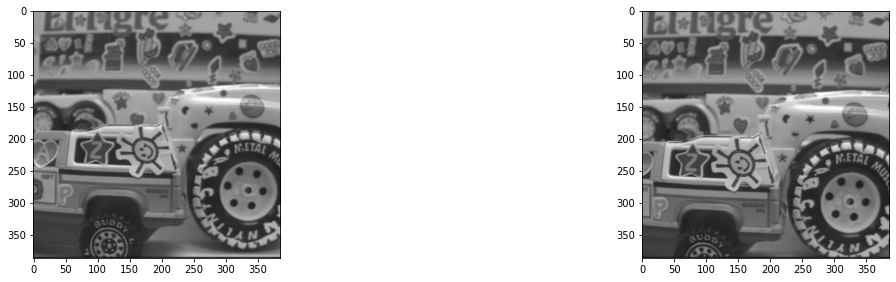

In [ ]:
display_images( [A, B] )

## 3.Calculate the Motion Vectors
 - pad each image on the its bottom and right border so that it has width and height that are multiples of the block size.

In [ ]:
def pad_image( img, blk_size ):
    return cv2.copyMakeBorder(src         = img,
                                top         = 0,
                                bottom     = img.shape[0] % blk_size,
                                left         = 0,
                                right        = img.shape[1] % blk_size,
                                borderType = cv2.BORDER_REFLECT)

 - segment image A into non-overlapping square blocks
     - for instance, if image A has the shape ( 30, 20) and we have a square block size of 10,
     - then, there will be
        - 3 blocks along the height direction
        - 2 blocks along the width direction
        - and overall 6 blocks
 ```
    |¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|¯¯¯¯¯¯¯¯¯¯¯|
    |   blk 1,1     |  blk 1,2  |
    |               |           |
    |¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|¯¯¯¯¯¯¯¯¯¯¯|
    |   blk 2,1     |  blk 2,2  |
    |               |           |
    |¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|¯¯¯¯¯¯¯¯¯¯¯|
    |   blk 3,1     |  blk 3,2  |
    |               |           |
    ¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
```
 - for each block ( indexed by blk_x, blk_y ), calculate its motion vector.
 1. the **Search Space** is defined as
 - $ SS = \{ (\Delta x, \Delta y) : \sqrt{(\Delta x)^2 + (\Delta y)^2} \leq r \} $, while r is our pre-defined search range, i.e. 50.

In [ ]:
# max search range in terms of number of pixels
search_pixel_range = 50

 2. the **Block** indexed by $(blk_x,blk_y)$ is a $w \times w$ sqaure centered at $(x,y) = ( (blk_x+\frac{1}{2})*w, (blk_y+\frac{1}{2})*w )$.
 - $ BLK (x,y)= \{ (u,v) | x-\frac{w}{2} \leq u \leq x+\frac{w}{2}, y-\frac{w}{2} \leq v \leq y+\frac{w}{2} \} = [x-\frac{w}{2},x+\frac{w}{2}] \times [y-\frac{w}{2},y+\frac{w}{2}] $

In [ ]:
block_size_list = [9, 11, 15, 21, 31]

 3. a **motion vector** of a block centered at (x,y) is the relative placement/transition (dx,dy) of the block which has the min absolute differences within the window.
 - $(\Delta x^*, \Delta y^*) = arg \min_{ (\Delta x,\Delta y ) \in SS } \sum_{(r,c) \in BLK(x,y)}{ \mid PIX(imgA, r, c) - PIX(imgB, r+\Delta x, c+\Delta y) \mid }$


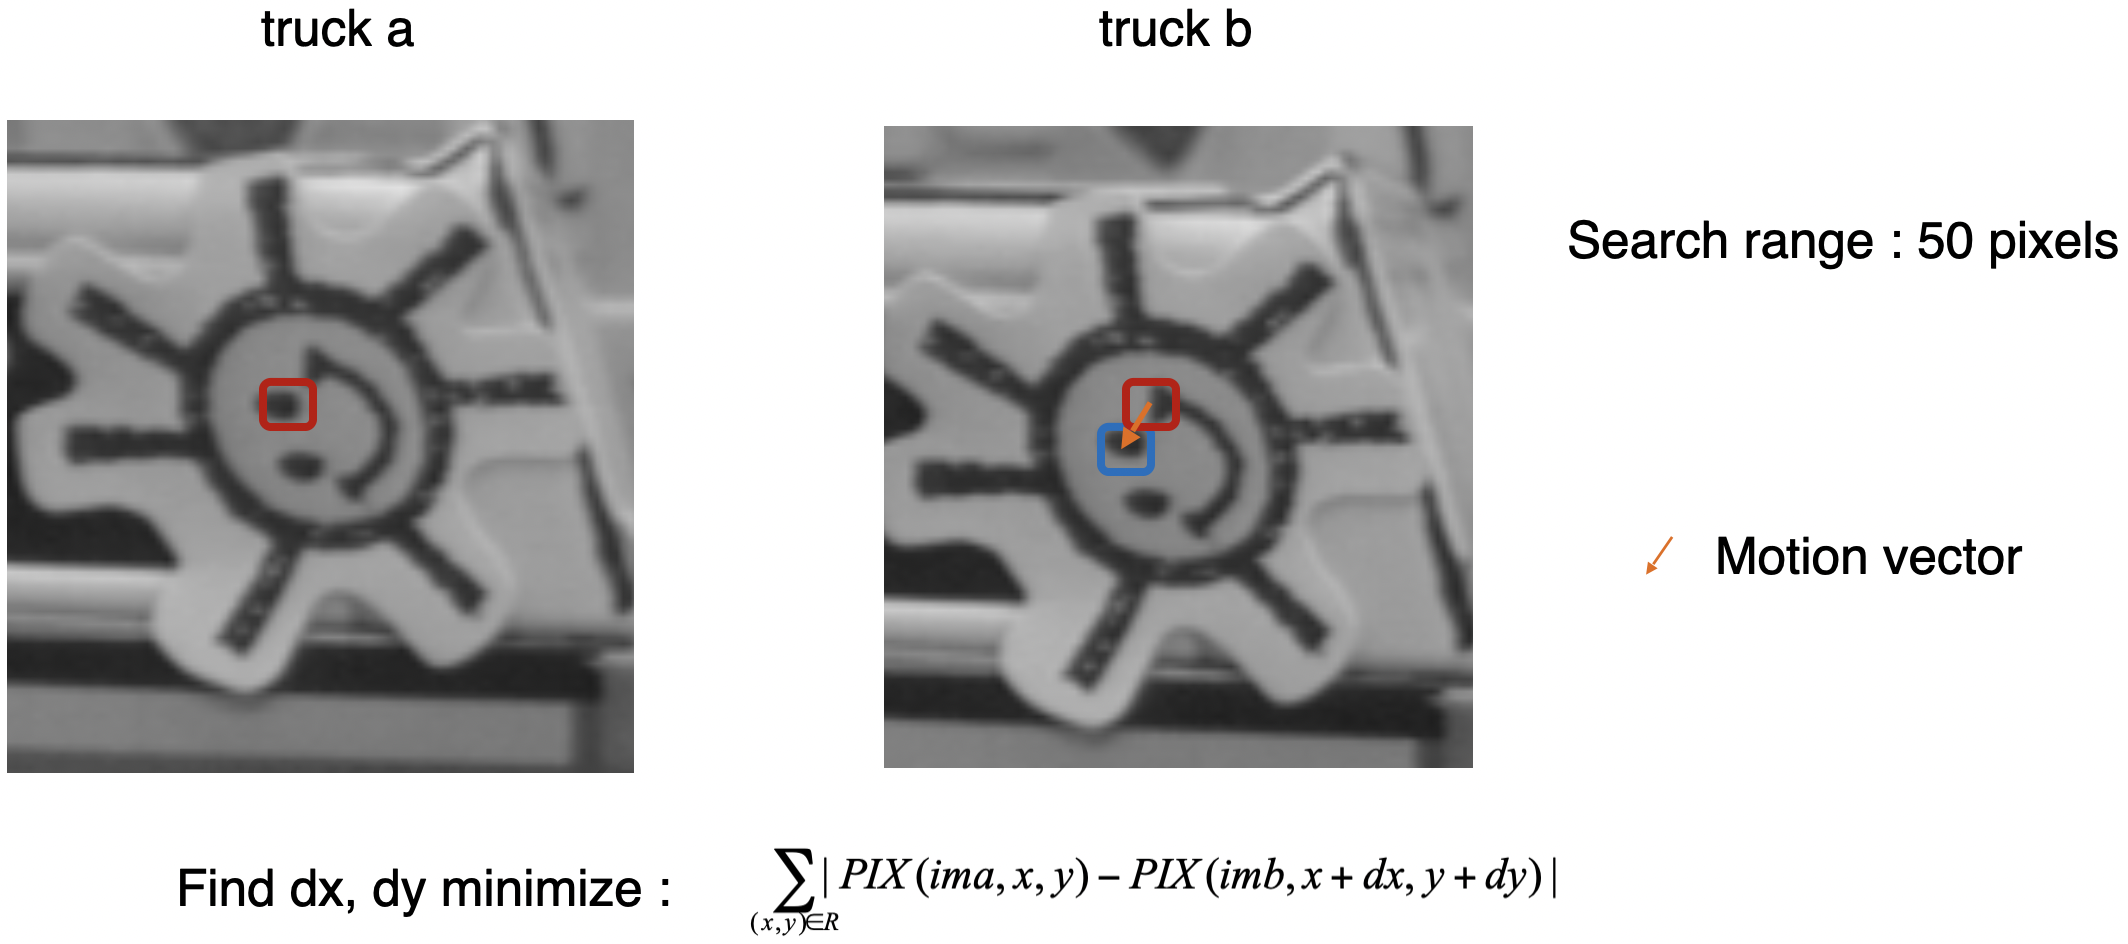

### Segment the images into non-overlapping blocks.

 - concerning a simple example of segmentation, please refer to the following description.

 - concerning the constraints on dx and dy, please refer to the following description.
 ```
constraints
1. maximum search range :
    |dx|^2 + |dy|^2 <= dist_pix^2
    |dy|^2 <= dist_pix^2 - |dx|^2
    |dy|   <= sqrt ( dist_pix^2 - |dx|^2 )
2.  the block on B ( with a small perturbation (dx,dy) )
    must entirely resides within the image boundary.
    (to avoid index out of bound error)
    0 <= dx+x*blk_size           ===> -x*blk_size <= dx
    0 <= dy+y*blk_size           ===> -y*blk_size <= dy
    dx+(x+1)*blk_size <= height  ===> dx <= height-(x+1)*blk_size
    dy+(y+1)*blk_size <= width   ===> dy <= width-(y+1)*blk_size
```

In [ ]:
def sum_abs_diff( A, B, x, y, dx, dy, blk_size ):
    return np.sum( np.absolute(
        A[     x*blk_size :    (x+1)*blk_size,     y*blk_size :   (y+1)*blk_size ]-
        B[ dx+x*blk_size : dx+(x+1)*blk_size, dy+y*blk_size: dy+(y+1)*blk_size ]) )

In [ ]:
def getMotionVector( A, B, blk_size, dist_pix ):
    assert A.shape==B.shape, "The shape between the two images is inconsistent."
    A = pad_image( A, blk_size )
    B = pad_image( B, blk_size )
    height, width   = A.shape
    n_row          = height // blk_size # the number of blocks along the rows, in the above example,  n_row = 3
    n_col           = width // blk_size # the number of blocks along the columns, in the above example,  n_col = 2
    motion_vector  = np.zeros( (n_row, n_col, 2), dtype=int ) # for each block ( overall there are n_row * n_col blocks ), we use a numpy array to store the 2 components (i.e. x and y) of the each motion vector.

    for blk_x in range (n_row):
        for blk_y in range (n_col):
            min_sum_abs_diff = sys.maxsize
            for dx in range ( max( - dist_pix, -blk_x*blk_size ), min( dist_pix+1, height-(blk_x+1)*blk_size+1 ) ):
                for dy in range ( max( - int ( math.sqrt( dist_pix**2 - dx**2 ) ), -blk_y*blk_size ), min(   int ( math.sqrt( dist_pix**2 - dx**2 ) )+1, width-(blk_y+1)*blk_size+1 ) ):
                    diff = sum_abs_diff( A, B, blk_x, blk_y, dx, dy, blk_size )
                    if diff < min_sum_abs_diff:
                        min_sum_abs_diff     = diff
                        motion_vector[blk_x][blk_y][0] = dx
                        motion_vector[blk_x][blk_y][1] = dy
    return motion_vector

## 4.Visualization of the motion vectors in each block.
 - we use the method [matplotlib.pyplot.quiver](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.quiver.html) to implement the visualization.
 - Call signature:
```
quiver( [X, Y], U, V, [C], **kwargs )
```
    - X, Y define the arrow locations : 1D or 2D array-like, optional
    - U, V define the arrow directions : 1D or 2D array-like
    - C optionally sets the color.

In [ ]:
def visualizeMotionVectorField( motionVec, block_size ):
    U = motion_vector[ :, :, 0 ]
    V = motion_vector[ :, :, 1 ]
    plt.quiver( U, V,  color='g', pivot='mid', angles='xy' )
    plt.title( "Motion Vector between truck (a) and truck (b), block size = " + '{:02d}'.format(block_size) )
    plt.savefig( "motion_vector_field_block_size_" + '{:02d}'.format(block_size) + ".png" )
    """
    the function quiver will have a orientation
        y
        ^
        ||
        ||
        ||-------> x
    but since plt / cv2 will have another orientation
        ||-------> x
        ||
        ||
        v
        y

    therefore, we need to invert the direction of the y-axis.
    """
    ax = plt.gca()
    ax.invert_yaxis()
    plt.show()

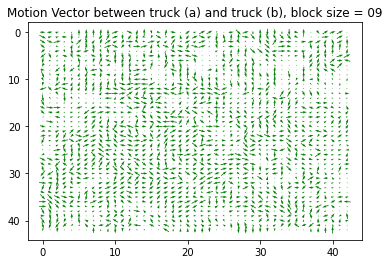

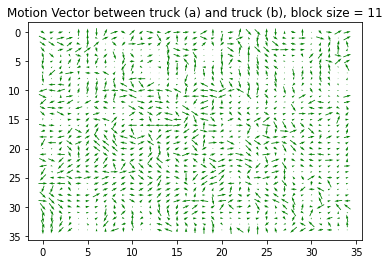

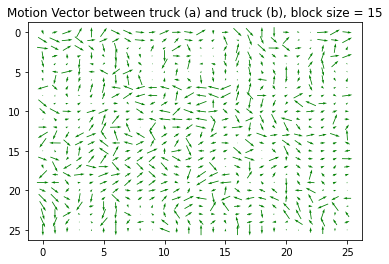

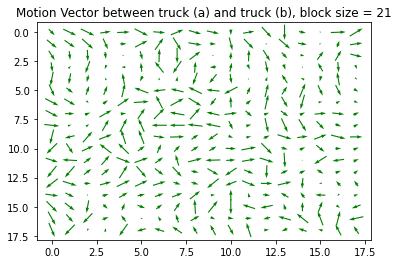

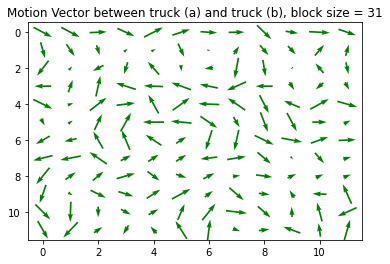

In [ ]:
for blk_size in block_size_list:
    motion_vector = getMotionVector( A, B, blk_size, search_pixel_range )
    visualizeMotionVectorField(motion_vector,blk_size)

Lastly, we validate this implementation by a simple example.

In [ ]:
img1 = cv2.imread('/content/1.jpg',0) # the original image, Image (t)
img2 = cv2.imread('/content/2.jpg',0) # the image after a small slapsed time, Image (t+dt)

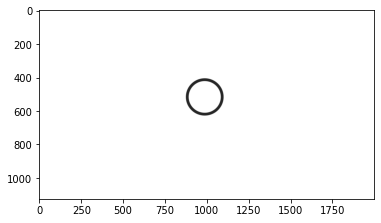

In [ ]:
plt.imshow( img1 )

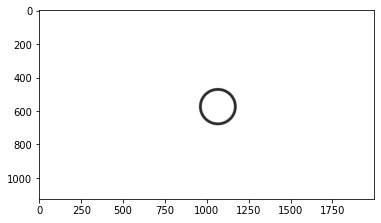

In [ ]:
plt.imshow( img2 )

 - in this example, the circle moves further right-ward and downward.
 - let's see the motion vector field.

In [ ]:
search_pixel_range = 100
blk_size = 201

motion_vector = getMotionVector( img1, img2, blk_size, search_pixel_range )

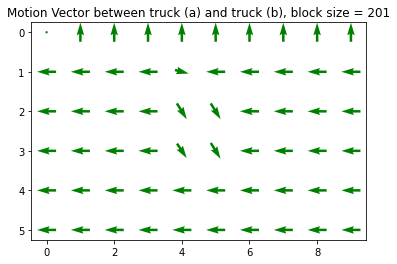

In [ ]:
visualizeMotionVectorField(motion_vector,blk_size)

### future tasks
 - set motion vector to be zero if, for each (dx,dy), the absolute differences are the same.
 -  how to chosse **search range** and **block size** to generate vector field that match one's intuition.
    - currently, within a cetain range, the larger the search space, the more accurate the motion vectors will represent.